## Problem Statement :
> To develop a machine learning model that predicts the credit risk of loan applicants and ensures its stability over time using LendingClub data.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [25]:
df = pd.read_csv(r"C:\Users\ASUS\OneDrive\Desktop\DS\loan dataset\loan_2014_18.csv")

In [26]:
df.head()

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,120122535,12000.0,12000.0,12000.0,36 months,7.97%,375.88,A,A5,associate,10+ years,OWN,42000.0,Source Verified,2017-09-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,923xx,CA,27.74,0.0,Jun-1996,715.0,719.0,0.0,NaN,80.0,9.0,1.0,11457.0,37%,16.0,w,0.00,0.00,13500.44,13500.44,12000.00,1500.44,0.0,0.0,0.0,May-2020,2591.95,NaN,May-2020,694.0,690.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,30502.0,1.0,2.0,1.0,3.0,8.0,19045.0,73.0,2.0,4.0,7117.0,53.0,31000.0,1.0,1.0,2.0,7.0,3389.0,7144.0,53.9,0.0,0.0,131.0,255.0,1.0,1.0,0.0,14.0,NaN,8.0,NaN,0.0,2.0,6.0,2.0,2.0,7.0,7.0,9.0,6.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,57180.0,30502.0,15500.0,26180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1,119374887,32000.0,32000.0,32000.0,36 months,11.99%,1062.71,B,B5,Nurse,10+ years,MORTGAGE,155000.0,Source Verified,2017-09-01,Current,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,080xx,NJ,12.35,2.0,Sep-2005,715.0,719.0,1.0,10.0,NaN,20.0,0.0,48309.0,34.1%,42.0,w,6158.89,6158.89,31838.67,31838.67,25841.11,5997.56,0.0,0.0,0.0,May-2020,0.00,Jul-2020,May-2020,674.0,670.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,405751.0,2.0,1.0,1.0,1.0,8.0,15582.0,78.0,4.0,7.0,14049.0,40.0,142600.0,0.0,2.0,2.0,8.0,22542.0,81313.0,34.5,0.0,0.0,91.0,144.0,1.0,1.0,3.0,1.0,24.0,1.0,10.0,0.0,7.0,10.0,12.0,27.0,3.0,18.0,36.0,10.0,20.0,0.0,0.0,0.0,5.0,94.9,0.0,0.0,0.0,527034.0,63891.0,124200.0,20034.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,CVD19SKIP,INCOMECURT,ACTIVE,2.0,0.00,Apr-2020,Jun-2020,Apr-2020,2.0,0.0,ACTIVE,123.08000,6189.66,1062.71,N
2,2,119321612,40000.0,40000.0,40000.0,60 months,15.

In [27]:
df = df.drop(df.columns[0], axis=1)
df.shape

(2029952, 141)

## Identifying the target (y)

In [28]:
df['loan_status'].value_counts()

loan_status
Fully Paid            1239089
Current                460148
Charged Off            313664
Late (31-120 days)       9532
In Grace Period          5644
Late (16-30 days)        1522
Default                   353
Name: count, dtype: int64

In [29]:
# Define the mapping
loan_status_mapping = {
    'Fully Paid': 1,
    'Current': 1,
    'In Grace Period': 1,
    'Late (16-30 days)': 0,
    'Late (31-120 days)': 0,
    'Charged Off': 0,
    'Default': 0
}

# Apply the mapping to the 'Loan_Status' column
df['loan_status_binary'] = df['loan_status'].map(loan_status_mapping)
df.drop('loan_status', axis=1, inplace=True)

In [30]:
df['loan_status_binary'].value_counts()

loan_status_binary
1    1704881
0     325071
Name: count, dtype: int64

## Missing values

In [31]:
df.isnull().sum()

id                                                  0
loan_amnt                                           0
funded_amnt                                         0
funded_amnt_inv                                     0
term                                                0
int_rate                                            0
installment                                         0
grade                                               0
sub_grade                                           0
emp_title                                      152606
emp_length                                     137908
home_ownership                                      0
annual_inc                                          0
verification_status                                 0
issue_d                                             0
pymnt_plan                                          0
url                                                 0
purpose                                             0
title                       

In [32]:
def missing_data_summary(df, threshold=0):
     return (pd.DataFrame(df.isna().sum())
       .reset_index()
       .rename(columns={'index': 'Column', 0: 'mis_count'})
       .query('mis_count > 0')  # Only include columns with missing values
       .assign(Missing_Percentage=lambda x: x['mis_count'] / df.shape[0] * 100)
       .query(f'Missing_Percentage > {threshold}')  # Filter by threshold
       .sort_values('mis_count', ascending=False)
       .reset_index(drop=True))

In [33]:
missing= missing_data_summary(df,51)
missing

,Column,mis_count,Missing_Percentage
0,hardship_loan_status,1956776,96.395186
1,hardship_reason,1956678,96.390358
2,hardship_status,1956677,96.390309
3,hardship_dpd,1956675,96.390210
4,hardship_end_date,1956674,96.390161
5,deferral_term,1956674,96.390161
6,hardship_type,1956674,96.390161
7,hardship_length,1956674,96.390161
8,payment_plan_start_date,1956674,96.390161
9,hardship_start_date,1956674,96.390161


In [34]:
# Convert the first column of 'missing' to a list
columns_to_drop = missing.iloc[:, 0].tolist()

# Drop the columns from the DataFrame
df = df.drop(columns=columns_to_drop)

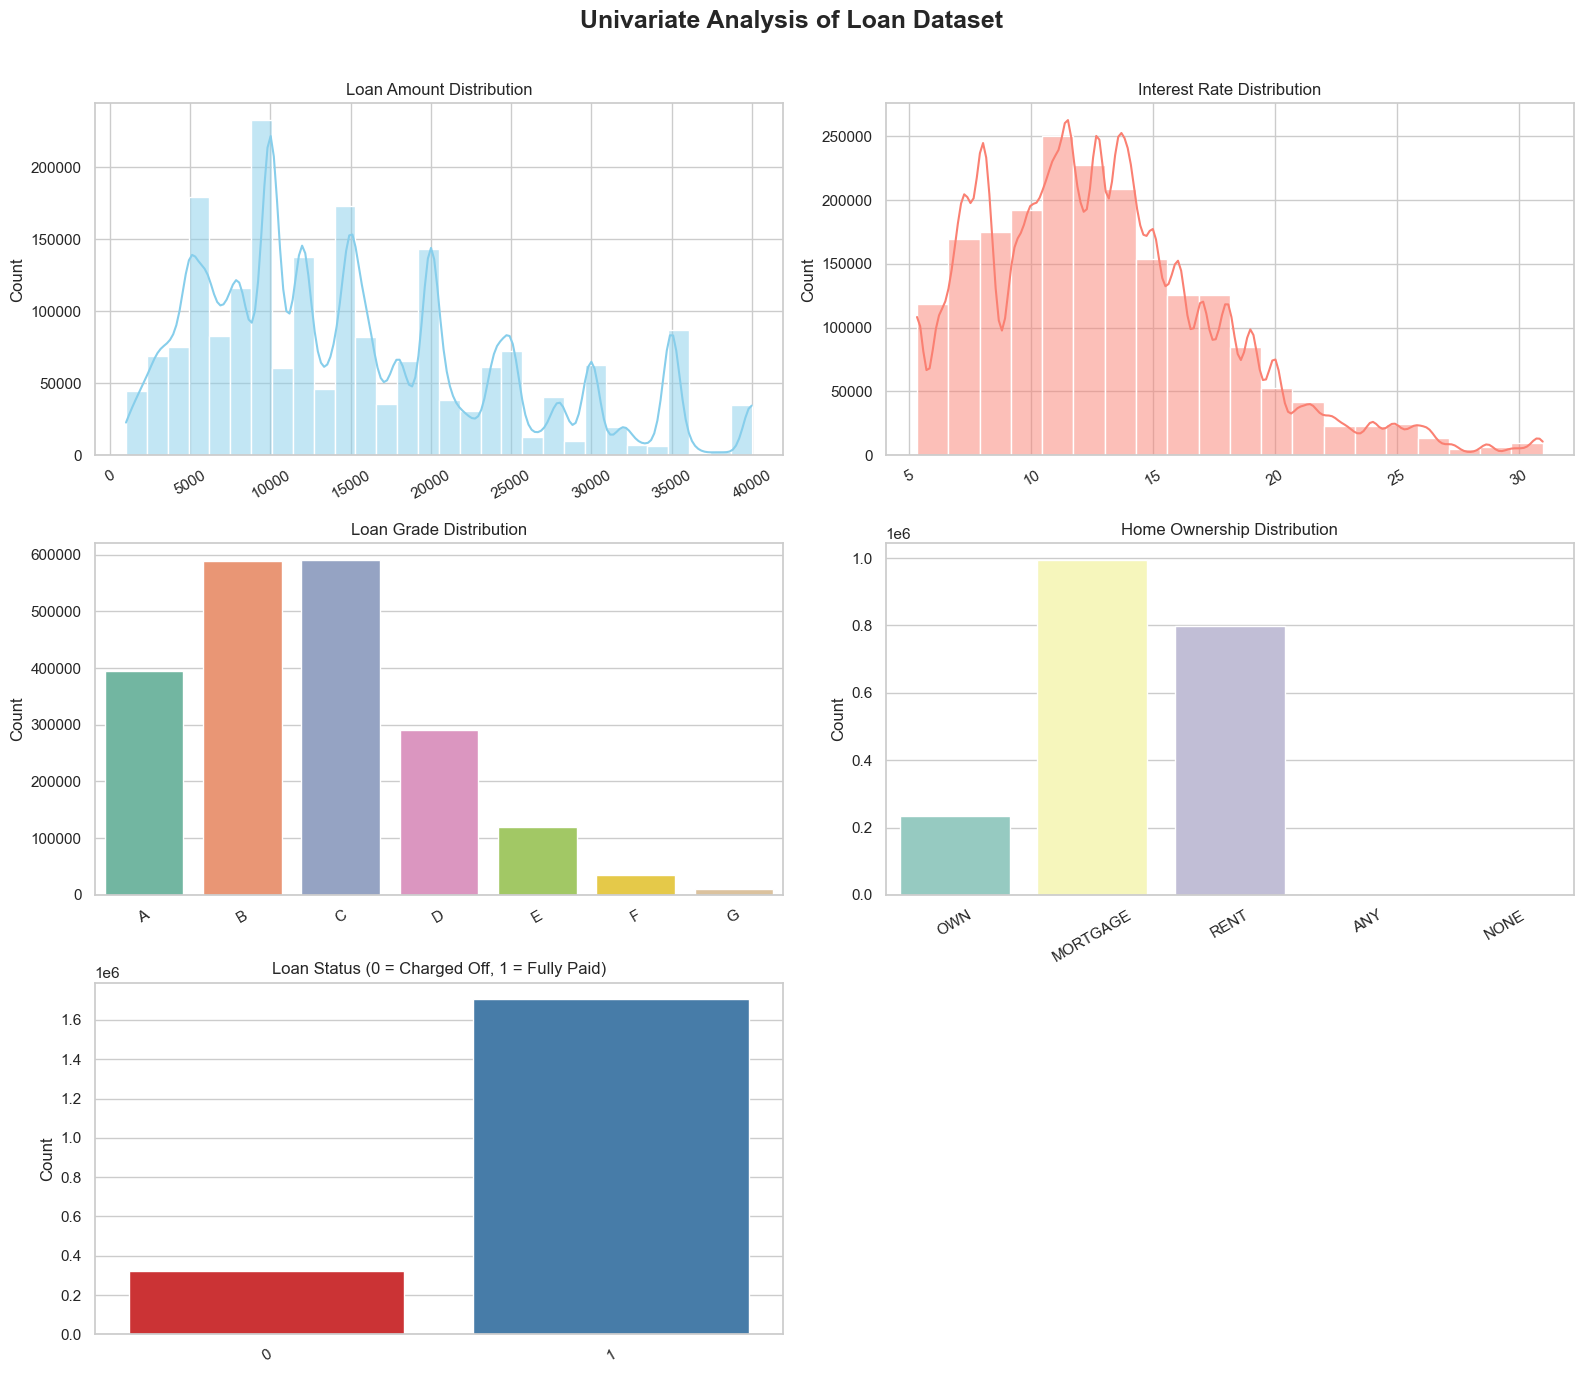

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
def univariate_analysis_grid(df):
    
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    fig.suptitle('Univariate Analysis of Loan Dataset', fontsize=18, fontweight='bold')

    # Plot 1: Loan Amount Distribution
    sns.histplot(df['loan_amnt'], kde=True, bins=30, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Loan Amount Distribution')

    # Plot 2: Interest Rate Distribution
    if df['int_rate'].dtype == 'O':  # If it's a string like '13.56%'
        df['int_rate'] = df['int_rate'].str.rstrip('%').astype(float)
    sns.histplot(df['int_rate'], kde=True, bins=20, ax=axes[0, 1], color='salmon')
    axes[0, 1].set_title('Interest Rate Distribution')

    # Plot 3: Grade Distribution
    sns.countplot(data=df, x='grade', order=sorted(df['grade'].dropna().unique()), ax=axes[1, 0], palette='Set2')
    axes[1, 0].set_title('Loan Grade Distribution')

    # Plot 4: Home Ownership Distribution
    sns.countplot(data=df, x='home_ownership', ax=axes[1, 1], palette='Set3')
    axes[1, 1].set_title('Home Ownership Distribution')

    # Plot 5: Loan Status
    sns.countplot(data=df, x='loan_status_binary', ax=axes[2, 0], palette='Set1')
    axes[2, 0].set_title('Loan Status (0 = Charged Off, 1 = Fully Paid)')

    # Remove Plot 6 (bottom-right)
    axes[2, 1].axis('off')

    # Final formatting
    for ax in axes.flatten():
        if ax.has_data():
            ax.set_xlabel('')
            ax.set_ylabel('Count')
            for label in ax.get_xticklabels():
                label.set_rotation(30)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
univariate_analysis_grid(df)

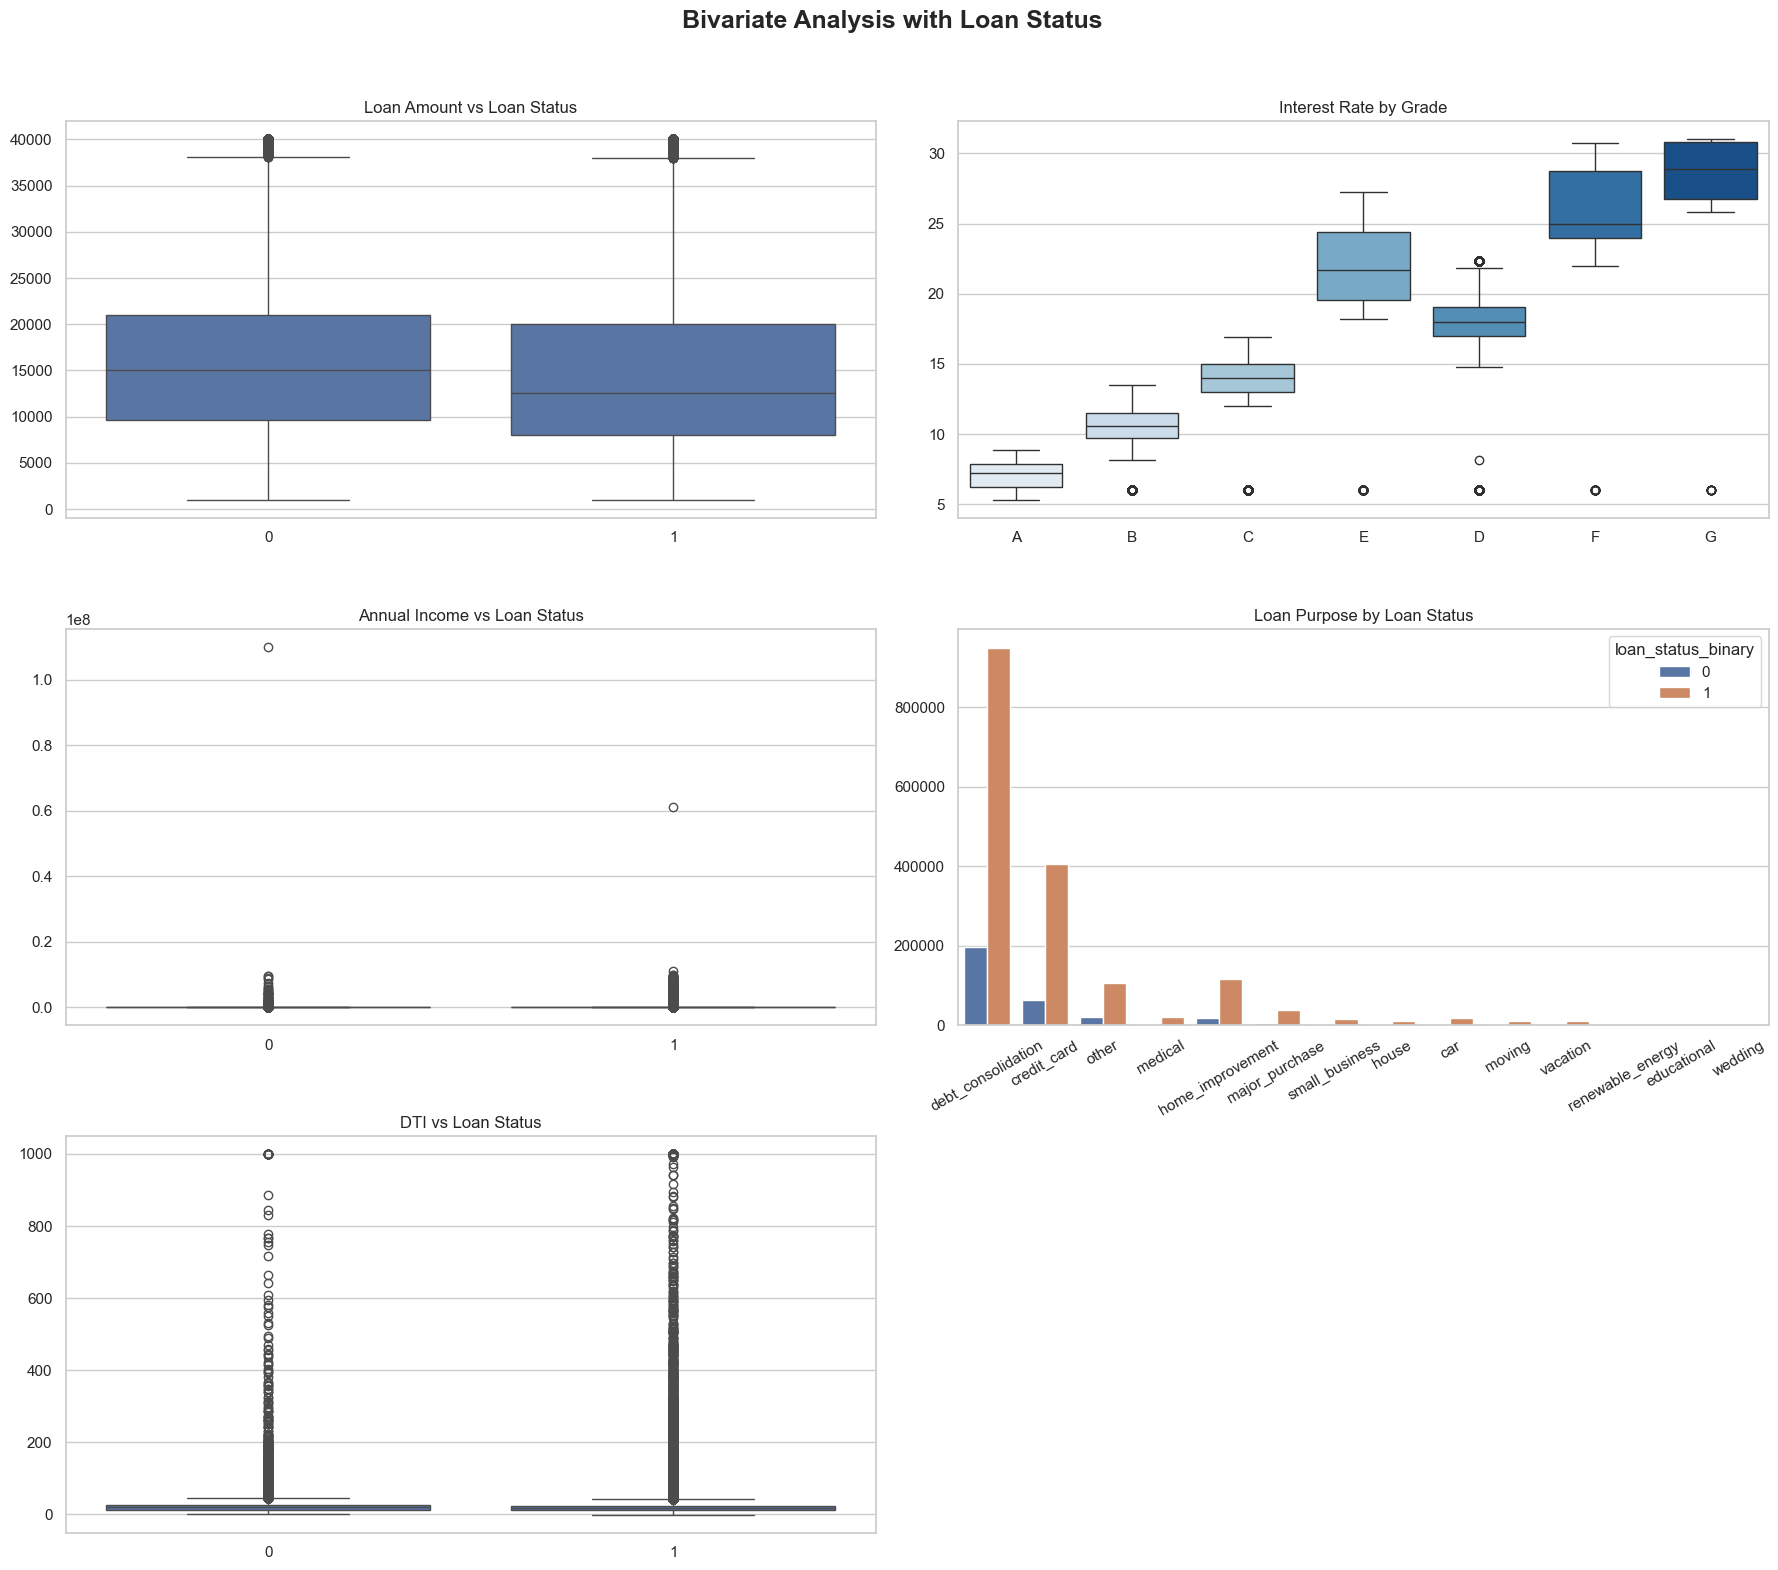

In [43]:
def bivariate_analysis_grid(df):
 
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(3, 2, figsize=(18, 16))
    fig.suptitle('Bivariate Analysis with Loan Status', fontsize=18, fontweight='bold')

    # Plot 1: Loan Amount vs Loan Status
    sns.boxplot(data=df, x='loan_status_binary', y='loan_amnt', ax=axes[0, 0])
    axes[0, 0].set_title('Loan Amount vs Loan Status')  

    # Plot 2: Interest Rate vs Grade
    if df['int_rate'].dtype == 'O':
        df['int_rate'] = df['int_rate'].str.rstrip('%').astype(float)
    sns.boxplot(data=df, x='grade', y='int_rate', ax=axes[0, 1], palette='Blues')
    axes[0, 1].set_title('Interest Rate by Grade')

    # Plot 3: Annual Income vs Loan Status
    sns.boxplot(data=df, x='loan_status_binary', y='annual_inc', ax=axes[1, 0])
    axes[1, 0].set_title('Annual Income vs Loan Status')

    # Plot 4: Loan Purpose vs Loan Status
    sns.countplot(data=df, x='purpose', hue='loan_status_binary', ax=axes[1, 1])
    axes[1, 1].set_title('Loan Purpose by Loan Status')
    axes[1, 1].tick_params(axis='x', rotation=30)

    # Plot 5: DTI vs Loan Status
    sns.boxplot(data=df, x='loan_status_binary', y='dti', ax=axes[2, 0])
    axes[2, 0].set_title('DTI vs Loan Status')

    # Plot 6 (bottom-right): Leave blank
    axes[2, 1].axis('off')

    # Optional: Beautify all axes
    for ax in axes.flatten():
        if ax.has_data():
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.title.set_fontsize(12)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
# Call the function
bivariate_analysis_grid(df)

## Categorical Features

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029952 entries, 0 to 2029951
Columns: 107 entries, id to loan_status_binary
dtypes: datetime64[ns](4), float64(83), int64(2), object(18)
memory usage: 1.6+ GB


In [45]:
df.select_dtypes(include=['object']).head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,pymnt_plan,url,purpose,title,zip_code,addr_state,revol_util,initial_list_status,application_type,hardship_flag,debt_settlement_flag
0,36 months,A,A5,associate,10+ years,OWN,Source Verified,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,923xx,CA,37%,w,Individual,N,N
1,36 months,B,B5,Nurse,10+ years,MORTGAGE,Source Verified,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,080xx,NJ,34.1%,w,Individual,Y,N
2,60 months,C,C4,Driver,9 years,MORTGAGE,Verified,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,778xx,TX,20.7%,w,Individual,N,N
3,36 months,A,A5,Senior Investigator,5 years,RENT,Not Verified,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,223xx,VA,57.7%,w,Individual,N,N
4,36 months,A,A3,Registered Nurse,< 1 year,MORTGAGE,Verified,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,750xx,TX,16.1%,w,Joint App,Y,N


In [41]:
df = df.apply(lambda col: col.str.strip() if col.dtypes == 'object' else col)

In [42]:
# convert dates to 'datetime' types
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%Y-%m-%d')
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y')
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%Y')

In [47]:
# int_rate and revol_util for int type  
# df['int_rate%']= pd.to_numeric(df['int_rate'].str.strip('%'))
df['revol_util%'] =pd.to_numeric(df['revol_util'].str.strip('%'))

In [48]:
columns_to_drop = {'title','zip_code','pymnt_plan', 'emp_title','int_rate','revol_util', 'url'}
df.drop(columns_to_drop, axis = 1, inplace = True)

In [49]:
df.debt_settlement_flag = np.where(df.debt_settlement_flag == 'Y',1,0)

In [ ]:
df.term_36_months = np.where(df.term == '36 months',1,0)
df.drop('term', axis=1, inplace=True)

In [51]:
df['emp_length'] = df['emp_length'].fillna('')
df['emp_length'] = pd.to_numeric(df['emp_length'].str.replace('<', '', regex=False).str[:2].str.strip(), errors='coerce')

In [ ]:
df.hardship_flag.fillna('N', inplace=True)
df.hardship_flag = np.where( df.hardship_flag == 'NaN','N', df.hardship_flag )

In [53]:
def get_sorted_unique_counts(df):
    # Select columns with categorical data
    object_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Get the number of unique entries in each categorical column
    object_nunique = {col: df[col].nunique() for col in object_cols}
    
    # Convert to DataFrame and sort by unique counts
    unique_counts = pd.DataFrame(list(object_nunique.items()), columns=['Column', 'Unique Count'])
    unique_counts = unique_counts.sort_values(by='Unique Count').reset_index(drop=True)
    
    return unique_counts

get_sorted_unique_counts(df)

,Column,Unique Count
0,initial_list_status,2
1,application_type,2
2,hardship_flag,2
3,verification_status,3
4,home_ownership,5
5,grade,7
6,purpose,14
7,sub_grade,35
8,addr_state,51


In [54]:
# unique_counts = (
#     df
#     .select_dtypes(include=['object', 'category'])
#     .nunique()
#     .sort_values()
#     .reset_index()
# )
# unique_counts.columns = ['Column', 'Unique Count']
# print(unique_counts)

In [55]:
def value_counter(df):
    value_series = pd.DataFrame()
    for col in df.select_dtypes(["object"]).columns:
        print(df[col].value_counts(dropna = False))

value_counter(df)

grade
C    591304
B    588545
A    394264
D    290516
E    120001
F     34791
G     10531
Name: count, dtype: int64
sub_grade
C1    132442
B5    128339
B4    122760
C2    118336
C3    117664
C4    116100
B1    113099
B3    112899
B2    111448
C5    106762
A5     96619
A4     85953
A1     81395
D1     73405
A3     66457
D2     65396
A2     63840
D3     58384
D4     50676
D5     42655
E1     30128
E2     26086
E3     23633
E5     20282
E4     19872
F1     11407
F2      7658
F3      6404
F4      5020
F5      4302
G1      3524
G2      2292
G3      1816
G4      1504
G5      1395
Name: count, dtype: int64
home_ownership
MORTGAGE    995479
RENT        799121
OWN         234352
ANY            996
NONE             4
Name: count, dtype: int64
verification_status
Source Verified    833961
Not Verified       667220
Verified           528771
Name: count, dtype: int64
purpose
debt_consolidation    1146650
credit_card            468324
home_improvement       136961
other                  126119
major

In [56]:
# # for col in df.select_dtypes(include=['object']).columns:
#     print(f"\n--- {col} ---")
#     print(df[col].value_counts(dropna=False))


In [57]:
df.drop('sub_grade', axis=1, inplace = True) 

## Date features

In [58]:
date_cols = df.select_dtypes(include=['datetime64']).columns
df[date_cols].head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,2017-09-01,1996-06-01,2020-05-01,2020-05-01
1,2017-09-01,2005-09-01,2020-05-01,2020-05-01
2,2017-09-01,2002-04-01,2020-05-01,2020-05-01
3,2017-09-01,2000-06-01,2020-05-01,2020-05-01
4,2017-09-01,2005-12-01,2020-04-01,2020-05-01


In [59]:
df[date_cols].isna().sum()

issue_d                  0
earliest_cr_line         0
last_pymnt_d          2190
last_credit_pull_d      58
dtype: int64

In [60]:
from datetime import datetime

# Assuming 'today' as the current date
today = pd.to_datetime("today")

#impute a today date to distinguish missing values.
df['last_pymnt_d'].fillna(today, inplace=True)
df['last_credit_pull_d'].fillna(today, inplace=True)

# Time differences
df['loan_age'] = (today - df['issue_d']).dt.days
df['credit_history_length'] = (df['issue_d'] - df['earliest_cr_line']).dt.days
df['time_since_last_payment'] = (today - df['last_pymnt_d']).dt.days
df['time_since_last_credit_pull'] = (today - df['last_credit_pull_d']).dt.days

# Temporal components
df['issue_year'] = df['issue_d'].dt.year
df['issue_month'] = df['issue_d'].dt.month

# Categorical flags
df['recent_payment'] = (df['time_since_last_payment'] <= 30).astype(int)
df['recent_credit_pull'] = (df['time_since_last_credit_pull'] <= 90).astype(int)

drop = {'issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d'}
df.drop(drop,axis=1, inplace=True)

## Numeric Features

In [61]:
y = df.loan_status_binary
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(exclude=['object']).drop('loan_status_binary',axis=1).columns

# Concatenate numeric columns explicitly
df_final = pd.concat([df[num_cols], pd.get_dummies(df[cat_cols], drop_first=True)], axis=1)

In [62]:
external_scores = {'last_fico_range_high','last_fico_range_low','fico_range_low', 'fico_range_high'}
df_final.drop(external_scores , axis=1, inplace=True)
df_final.drop('id', axis=1, inplace=True)

In [63]:
from sklearn.impute import SimpleImputer
# Define imputer (mean for numeric features, most frequent for categorical)
imputer = SimpleImputer(strategy='mean')

# Apply imputation to X
X_imputed = imputer.fit_transform(df_final)

# Convert back to DataFrame if necessary
df_final = pd.DataFrame(X_imputed, columns=df_final.columns)

In [64]:
# Compute the absolute correlations
correlations = df_final.corrwith(y).abs()

# Convert to DataFrame and sort
correlation_df = correlations.sort_values(ascending=False).reset_index()
correlation_df.columns = ['name', 'correlation']

# Display the resulting DataFrame
correlation_df.head(30)

,name,correlation
0,recoveries,0.528278
1,collection_recovery_fee,0.520392
2,debt_settlement_flag,0.357692
3,total_rec_prncp,0.343479
4,time_since_last_credit_pull,0.296583
5,last_pymnt_amnt,0.242224
6,total_pymnt_inv,0.238166
7,total_pymnt,0.238158
8,time_since_last_payment,0.208620
9,out_prncp,0.142230


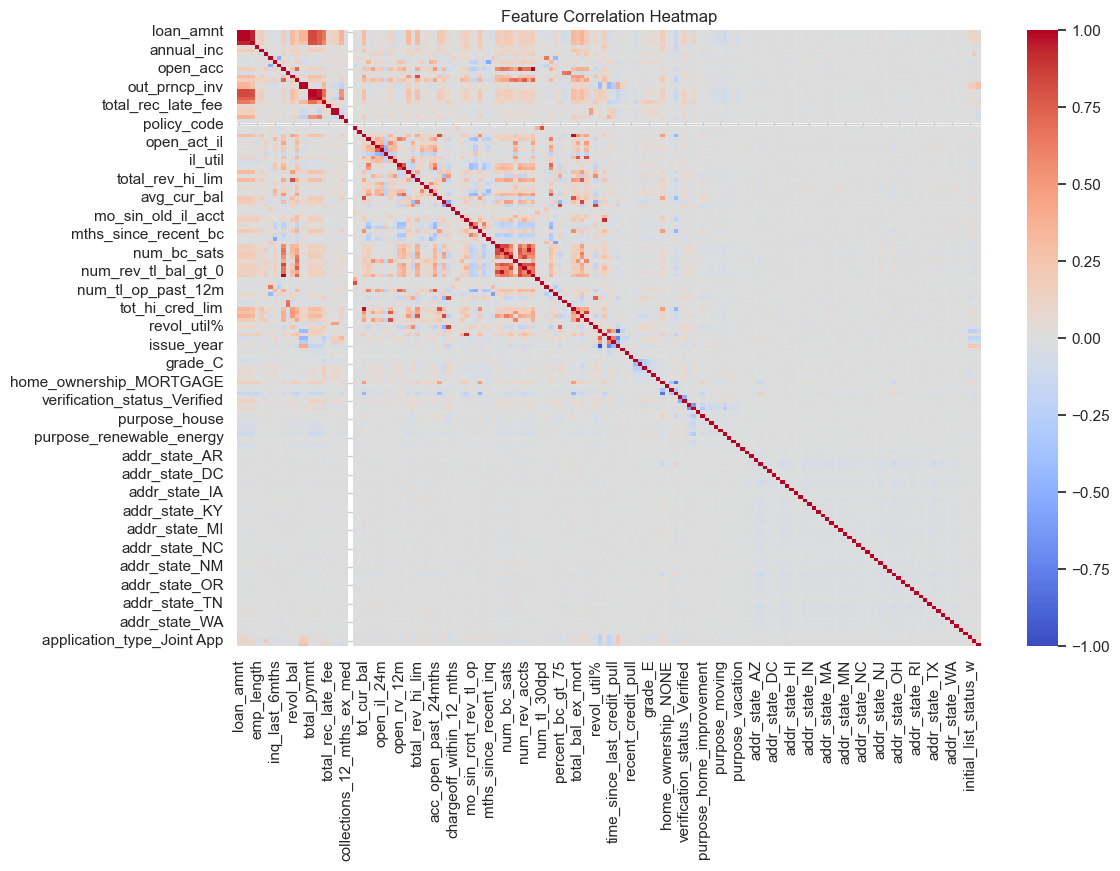

In [65]:
# Compute correlation matrix for independent variables
feature_corr = df_final.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(feature_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

In [66]:
# Identify pairs of highly correlated features
threshold = 0.8
high_corr_pairs = feature_corr.abs().stack().reset_index()
high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]
high_corr_pairs = high_corr_pairs[high_corr_pairs[0] > threshold]
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs

,Feature1,Feature2,Correlation
1,loan_amnt,funded_amnt,0.999999
2,loan_amnt,funded_amnt_inv,0.999994
3,loan_amnt,installment,0.945133
16,loan_amnt,total_pymnt,0.828604
17,loan_amnt,total_pymnt_inv,0.828653
166,funded_amnt,loan_amnt,0.999999
168,funded_amnt,funded_amnt_inv,0.999995
169,funded_amnt,installment,0.945134
182,funded_amnt,total_pymnt,0.828604
183,funded_amnt,total_pymnt_inv,0.828654


## Feature selection & training

In [67]:
features_to_drop = set()

for f1, f2 in high_corr_pairs[['Feature1', 'Feature2']].values:
    corr1 = correlation_df.loc[correlation_df['name'] == f1, 'correlation'].values[0]
    corr2 = correlation_df.loc[correlation_df['name'] == f2, 'correlation'].values[0]
    
    drop_feature = f2 if corr1 >= corr2 else f1
    features_to_drop.add(drop_feature)

# STEP 4: Keep only selected features
selected_features = [col for col in df_final.columns if col not in features_to_drop]

# STEP 5: Print summary
print("Dropped features:", features_to_drop)
print("Remaining features count:", len(selected_features))

Dropped features: {'funded_amnt_inv', 'installment', 'funded_amnt', 'total_pymnt_inv', 'num_actv_bc_tl', 'num_tl_30dpd', 'num_sats', 'total_pymnt', 'tot_cur_bal', 'revol_bal', 'issue_year', 'open_acc', 'out_prncp_inv', 'total_bal_il', 'total_bc_limit', 'num_bc_tl', 'total_il_high_credit_limit', 'num_op_rev_tl', 'credit_history_length', 'revol_util%', 'num_bc_sats', 'num_rev_tl_bal_gt_0', 'bc_util', 'loan_amnt', 'collection_recovery_fee'}
Remaining features count: 142


## Selection based on correlation

In [ ]:
# indicate loan duration
df_final['loan_amnt_div_instlmnt']=df_final['loan_amnt']/df_final['installment']

In [69]:
#The columns are dropped because they are either redundant, highly correlated, cause data leakage, or have low predictive value.
drop={'funded_amnt_inv', 'total_bal_il', 'total_pymnt', 'num_rev_tl_bal_gt_0',
      'issue_year', 'num_sats', 'num_op_rev_tl', 'total_bc_limit', 
      'total_il_high_credit_limit', 'credit_history_length', 'num_bc_tl',
      'out_prncp_inv', 'num_tl_30dpd', 'bc_util', 'tot_cur_bal',
      'num_actv_bc_tl', 'open_acc', 'funded_amnt', 'loan_amnt',
      'installment','collection_recovery_fee', 'total_pymnt_inv', 
      'revol_bal', 'revol_util%', 'num_bc_sats'}
df_final.drop(drop,axis=1, inplace=True)

## Further features selection with RFE

In [70]:
X = df_final

In [71]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [72]:
# Train Random Forest for feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Select features with importance above a threshold
model = SelectFromModel(rf, prefit=True, threshold="mean")
X_train_selected = model.transform(X_train_scaled)
X_test_selected = model.transform(X_test_scaled)

print(f"Original features: {X.shape[1]}, Selected features: {X_train_selected.shape[1]}")

# Get the mask of selected features
selected_features_mask = model.get_support()

# Get the names of the selected features
selected_features_names = np.array(X.columns)[selected_features_mask]
selected_features_names

Original features: 143, Selected features: 11


array(['out_prncp', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt',
       'debt_settlement_flag', 'loan_age', 'time_since_last_payment',
       'time_since_last_credit_pull', 'loan_amnt_div_instlmnt'],
      dtype=object)

## Training Models

In [73]:
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,fbeta_score,roc_auc_score,classification_report,RocCurveDisplay
from sklearn.metrics import classification_report

# Define a function to evaluate and display metrics
def evaluate_model(model, X_test, y_test, model_name):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    print(f"Results for {model_name}:")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\n")
    
    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Recall": recall,
        "F2": f2,
        "AUC": auc
    }

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

=== Logistic Regression ===
Confusion Matrix:
 [[ 55942   8968]
 [  1639 339442]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91     64910
           1       0.97      1.00      0.98    341081

    accuracy                           0.97    405991
   macro avg       0.97      0.93      0.95    405991
weighted avg       0.97      0.97      0.97    405991

Accuracy: 0.9738738050843492
Recall: 0.9951946898244112
F2 Score: 0.9909361290194507
AUC: 0.9812089097470459


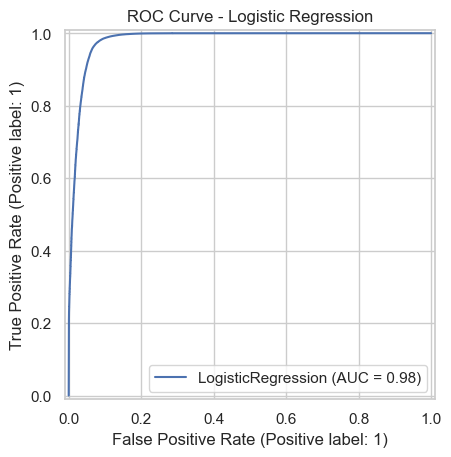

In [75]:
# Train the model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_selected, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test_selected)
y_prob_lr = lr_model.predict_proba(X_test_selected)[:, 1]

# Evaluate
print("=== Logistic Regression ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F2 Score:", fbeta_score(y_test, y_pred_lr, beta=2))
print("AUC:", roc_auc_score(y_test, y_prob_lr))

# Plot ROC Curve
RocCurveDisplay.from_estimator(lr_model, X_test_selected, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

=== Random Forest ===
Confusion Matrix:
 [[ 63414   1496]
 [   302 340779]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     64910
           1       1.00      1.00      1.00    341081

    accuracy                           1.00    405991
   macro avg       1.00      0.99      0.99    405991
weighted avg       1.00      1.00      1.00    405991

Accuracy: 0.9955713303989497
Recall: 0.9991145798212155
F2 Score: 0.9984155621795161
AUC: 0.9984922405470038


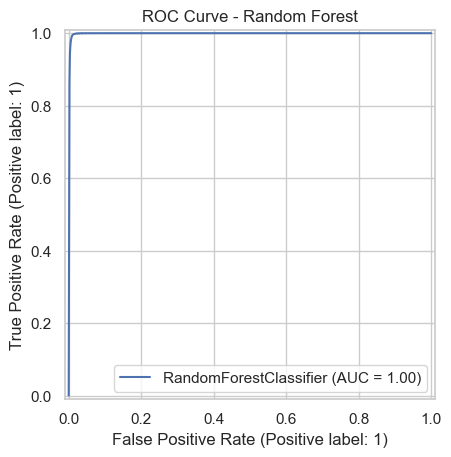

In [76]:
# Train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test_selected)
y_prob_rf = rf_model.predict_proba(X_test_selected)[:, 1]

# Evaluate
print("=== Random Forest ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F2 Score:", fbeta_score(y_test, y_pred_rf, beta=2))
print("AUC:", roc_auc_score(y_test, y_prob_rf))

# Plot ROC
RocCurveDisplay.from_estimator(rf_model, X_test_selected, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()

=== Gradient Boosting ===
Confusion Matrix:
 [[ 59806   5104]
 [   266 340815]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96     64910
           1       0.99      1.00      0.99    341081

    accuracy                           0.99    405991
   macro avg       0.99      0.96      0.97    405991
weighted avg       0.99      0.99      0.99    405991

Accuracy: 0.9867731058077642
Recall: 0.9992201265974945
F2 Score: 0.9963934949594883
AUC: 0.9954795017088434


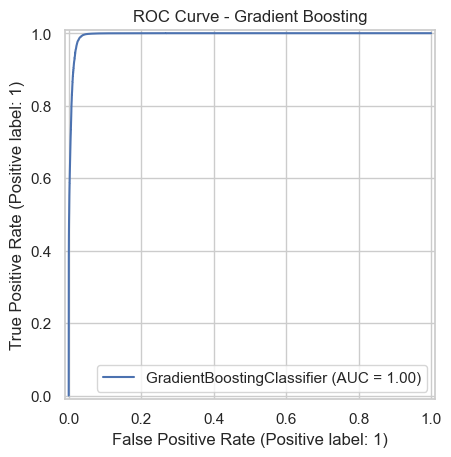

In [77]:
# Train
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_selected, y_train)

# Predict
y_pred_gb = gb_model.predict(X_test_selected)
y_prob_gb = gb_model.predict_proba(X_test_selected)[:, 1]

# Evaluate
print("=== Gradient Boosting ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Recall:", recall_score(y_test, y_pred_gb))
print("F2 Score:", fbeta_score(y_test, y_pred_gb, beta=2))
print("AUC:", roc_auc_score(y_test, y_prob_gb))

# Plot ROC
RocCurveDisplay.from_estimator(gb_model, X_test_selected, y_test)
plt.title("ROC Curve - Gradient Boosting")
plt.show()

=== Neural Network (MLPClassifier) ===
Confusion Matrix:
 [[ 63561   1349]
 [   242 340839]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     64910
           1       1.00      1.00      1.00    341081

    accuracy                           1.00    405991
   macro avg       1.00      0.99      0.99    405991
weighted avg       1.00      1.00      1.00    405991

Accuracy: 0.9960811939180918
Recall: 0.9992904911150138
F2 Score: 0.9986422597672914
AUC: 0.9988696228025855


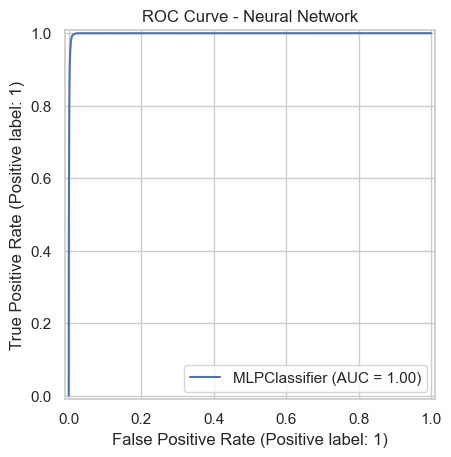

In [78]:
# Train
nn_model = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=300, random_state=42)
nn_model.fit(X_train_selected, y_train)

# Predict
y_pred_nn = nn_model.predict(X_test_selected)
y_prob_nn = nn_model.predict_proba(X_test_selected)[:, 1]

# Evaluate
print("=== Neural Network (MLPClassifier) ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nn))
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print("Recall:", recall_score(y_test, y_pred_nn))
print("F2 Score:", fbeta_score(y_test, y_pred_nn, beta=2))
print("AUC:", roc_auc_score(y_test, y_prob_nn))

# Plot ROC
RocCurveDisplay.from_estimator(nn_model, X_test_selected, y_test)
plt.title("ROC Curve - Neural Network")
plt.show()

In [79]:
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "Neural Network": nn_model
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test_selected)
    y_prob = model.predict_proba(X_test_selected)[:, 1]
    results.append([
        name,
        accuracy_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        fbeta_score(y_test, y_pred, beta=2),
        roc_auc_score(y_test, y_prob)
    ])

summary_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Recall", "F2 Score", "AUC"])
print("Summary of Results:")
print(summary_df)

Summary of Results:
                 Model  Accuracy    Recall  F2 Score       AUC
0  Logistic Regression  0.973874  0.995195  0.990936  0.981209
1        Random Forest  0.995571  0.999115  0.998416  0.998492
2    Gradient Boosting  0.986773  0.999220  0.996393  0.995480
3       Neural Network  0.996081  0.999290  0.998642  0.998870
